In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import onnxruntime as rt
import onnx
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import to_onnx
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [12]:
# biased_features = [
#     "persoon_geslacht_vrouw",                   # gender
#     "persoon_leeftijd_bij_onderzoek",           # age (strongly discriminative)
#     "persoonlijke_eigenschappen_spreektaal",    # migrant background proxy
#     "adres_recentste_wijk_feijenoord",          # neighborhood proxy
#     "relatie_overig_kostendeler",               # poverty proxy
#     "contacten_onderwerp_no_show"               # behavioral proxy
# ]

In [13]:
# Let's load the dataset
data = pd.read_csv('data/synth_data_for_training.csv')


# Define discriminatory prefixes
biased_prefixes = [
    "adres_",
    "persoonlijke_eigenschappen_spreektaal",
    "persoonlijke_eigenschappen_nl_",
    "persoonlijke_eigenschappen_taaleis_",
    "relatie_",
    "belemmering_",
    "beschikbaarheid_",
    "contacten_"
]

# Filter dataframe to only biased variables
biased_features = [
    col for col in data.columns
    if col != 'checked' and any(col.startswith(p) for p in biased_prefixes)
]

y = data['checked']
X = data.drop(['checked'], axis=1)
X = X.astype(np.float32)

print("Number of biased features used:", len(biased_features))
print("Example biased features:", biased_features[:20])

Number of biased features used: 164
Example biased features: ['adres_aantal_brp_adres', 'adres_aantal_verschillende_wijken', 'adres_aantal_verzendadres', 'adres_aantal_woonadres_handmatig', 'adres_dagen_op_adres', 'adres_recentst_onderdeel_rdam', 'adres_recentste_buurt_groot_ijsselmonde', 'adres_recentste_buurt_nieuwe_westen', 'adres_recentste_buurt_other', 'adres_recentste_buurt_oude_noorden', 'adres_recentste_buurt_vreewijk', 'adres_recentste_plaats_other', 'adres_recentste_plaats_rotterdam', 'adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other']


In [14]:
BIASED_WEIGHT = 1.5
OTHERS_WEIGHT = 0.5

feature_weights = {}
for feature in X.columns:
    if feature in biased_features:
        feature_weights[feature] = BIASED_WEIGHT # Higher weight for biased features
    else:
        feature_weights[feature] = OTHERS_WEIGHT # Lower weight for other features

X_weighted = X.copy()
for feature in X.columns:
    X_weighted[feature] *= feature_weights[feature]

print(f"Original feature matrix shape: {X.shape}")
print(f"Weighted feature matrix shape: {X_weighted.shape}")

Original feature matrix shape: (12645, 315)
Weighted feature matrix shape: (12645, 315)


In [15]:
# Split the dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [16]:
# Select data based on variance (not the final version yet, for now just for testing)
selector = VarianceThreshold()

In [17]:
# classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
bad_model = Pipeline([
    ("scaler", StandardScaler(with_mean=False)),  
    ("gb", GradientBoostingClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

Classification Report:

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      2856
           1       0.92      0.45      0.61       306

    accuracy                           0.94      3162
   macro avg       0.93      0.72      0.79      3162
weighted avg       0.94      0.94      0.93      3162



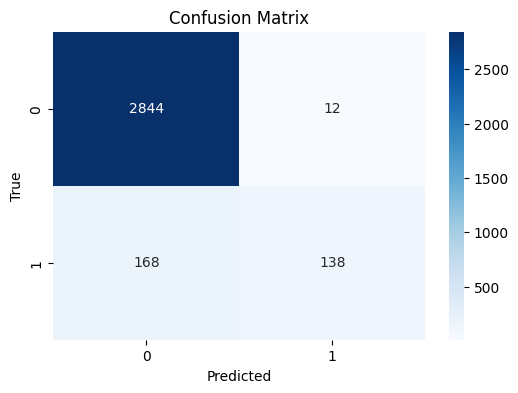

In [18]:
# Train the model
bad_model.fit(X_train, y_train)
# Predictions on test set
y_pred = bad_model.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [19]:
# Convert the model to ONNX
onnx_model = convert_sklearn(
    bad_model, initial_types=[('X', FloatTensorType((None, X.shape[1])))],
    target_opset=12)

# Let's check the accuracy of the converted model
sess = rt.InferenceSession(onnx_model.SerializeToString())
y_pred_onnx =  sess.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)

Accuracy of the ONNX model:  0.9430740037950665


In [20]:
# Let's save the model
onnx.save(onnx_model, "subgroup_2/model_2.onnx")

# Let's load the model
new_session = rt.InferenceSession("subgroup_2/model_2.onnx")

# Let's predict the target
y_pred_onnx2 =  new_session.run(None, {'X': X_test.values.astype(np.float32)})

accuracy_onnx_model = accuracy_score(y_test, y_pred_onnx2[0])
print('Accuracy of the ONNX model: ', accuracy_onnx_model)


Accuracy of the ONNX model:  0.9430740037950665
